In [1]:
import pandas as pd
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

from utils.Perspectiver import Perspectiver

/home/liingfeng/Desktop/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class CardsDataset(Dataset):

    def __init__(self, path: str = "data/", transform = None, seed: int = 55, scale: float = 1, split: str = "train", convert: str = "L"):
        self.data = pd.read_csv(os.path.join(path, "cards.csv"))
        self.data = self.data[self.data["data set"]==split].drop(columns=["data set", "card type"])
        
        if transform is not None: self.transform = transform
        else: self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

        self.scale = scale
        self.path = path

        if seed != None :
            self.data = self.data.sample(frac=1, random_state=seed).reset_index(drop=True)
        
        self.data["filepaths"] = self.data["filepaths"].apply(lambda x: os.path.join(self.path, x))
        self.labels = pd.get_dummies(self.data, columns=['labels'], drop_first=True, dtype=int).drop(columns=["class index", "filepaths"])
        self.convert = convert

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_path = self.data.iloc[index]["filepaths"]

        image = Image.open(img_path).convert(self.convert)

        original_width, original_height = image.size
        image = image.resize((max(1, int(original_width * self.scale)), max(1, int(original_height * self.scale))))

        image = self.transform(image)
        
        label = torch.tensor(self.labels.iloc[index].values.astype(int), dtype=torch.int8)
        return image, label
    
    def decode_label(self, encoed_label):
        return np.array(self.labels.columns.to_list())[np.argmax(encoed_label)].removeprefix("labels_")


In [3]:
CardsDataset().data.head()

,class index,filepaths,labels
0,18,data/train/jack of hearts/148.jpg,jack of hearts
1,10,data/train/five of hearts/119.jpg,five of hearts
2,9,data/train/five of diamonds/006.jpg,five of diamonds
3,21,data/train/king of clubs/017.jpg,king of clubs
4,39,data/train/six of hearts/049.jpg,six of hearts


In [ ]:
scale_1 = 1
scale_2 = 0.50
dataset_scale_100 = CardsDataset(scale=scale_1)
dataset_scale_050 = CardsDataset(scale=scale_2)

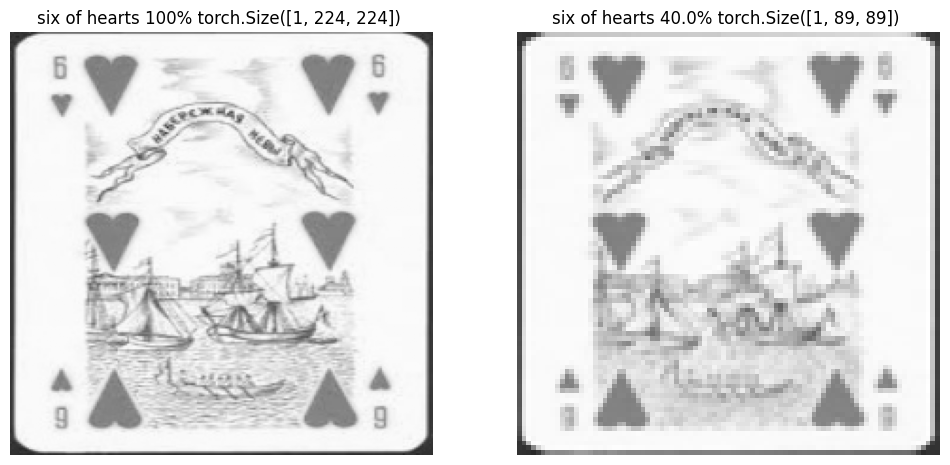

In [181]:
import random
idx = random.randint(0, len(dataset_scale_050))
img_1 , label_1 = dataset_scale_100.__getitem__(idx)
img_2 , label_2 = dataset_scale_050.__getitem__(idx)
Perspectiver.plotComparison(imageBefore = Perspectiver.grayscale_to_rgb(img_1.numpy()[0]) , 
                            imageAfter = Perspectiver.grayscale_to_rgb(img_2.numpy()[0]) , 
                            titleBefore = f"{dataset_scale_100.decode_label(label_1)} {scale_1*100}% {img_1.size()} ",
                            titleAfter = f"{dataset_scale_050.decode_label(label_2)} {scale_2*100}% {img_2.size()} "
                            )